In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sqlite3
import seaborn as sns

sns.set(style='white', palette="Set2", color_codes=False)
sns.set_style("ticks")

%matplotlib inline

In [2]:
def get_dataframes(query, databases):
    dataframes = []
    for database in databases:
        db = sqlite3.connect(database)
        dataframes += [pd.read_sql_query(query, db)]
    return pd.concat(dataframes)

In [19]:
query = 'select * from tasks'
databases = [             
             '../theta-scaling/data.db'
             ]
tasks = get_dataframes(query, databases)
tasks.head()

,platform,start_submit,end_submit,returned,num_workers,tasks_per_trial,container_type
0,Theta,1.572025e+09,1.572025e+09,1.572025e+09,1,5000,matminer-util
1,Theta,1.572026e+09,1.572026e+09,1.572026e+09,1,1000,matminer-util
2,Theta,1.572026e+09,1.572026e+09,1.572026e+09,2,1000,matminer-util
3,Theta,1.572026e+09,1.572026e+09,1.572026e+09,4,1000,matminer-util
4,Theta,1.572027e+09,1.572027e+09,1.572027e+09,8,1000,matminer-util


In [20]:
tasks['completion time'] = tasks['returned'] - tasks['start_submit']
tasks.head()

,platform,start_submit,end_submit,returned,num_workers,tasks_per_trial,container_type,completion time
0,Theta,1.572025e+09,1.572025e+09,1.572025e+09,1,5000,matminer-util,80.920417
1,Theta,1.572026e+09,1.572026e+09,1.572026e+09,1,1000,matminer-util,16.680086
2,Theta,1.572026e+09,1.572026e+09,1.572026e+09,2,1000,matminer-util,9.852832
3,Theta,1.572026e+09,1.572026e+09,1.572026e+09,4,1000,matminer-util,6.559336
4,Theta,1.572027e+09,1.572027e+09,1.572027e+09,8,1000,matminer-util,6.539137


The smallest time of noop container is 3.2061290740966797, 
            leading to a throughput of 311.9026018257696 tasks/s
The smallest time of oqmd container is 9.396304368972778, 
            leading to a throughput of 106.42481987940562 tasks/s
The smallest time of matminer-util container is 6.539136648178101, 
            leading to a throughput of 152.92538660720825 tasks/s
The smallest time of cifar10 container is 18.759822607040405, 
            leading to a throughput of 53.30540810256427 tasks/s
The smallest time of inception container is 9.222194910049438, 
            leading to a throughput of 108.4340560738202 tasks/s


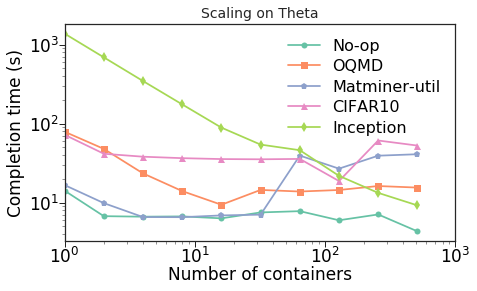

In [55]:
labels = {
    'noop': 'no-op',
    #'sleep10ms': '10 ms sleep',
    #'sleep100ms': '100 ms sleep',
    'sleep1000ms': '1s sleep',
    #'sleep10s': '10s sleep',
    #'sleep100s': '100s sleep'
}

containers = {
    'noop': 'No-op',
    'oqmd': 'OQMD',
    'matminer-util':'Matminer-util',
    'cifar10': 'CIFAR10',
    'inception': 'Inception',
}

tasks_per_trial = 1000

fig, ax = plt.subplots(figsize=(7,4))
platforms = [
            'Theta',
            ]
markers = ['o', 's', 'p', '^', 'd', 'X']
marker_sizes = [6, 7, 7, 7, 7, 7, 6]
colors = sns.color_palette("Set2")
count = 0
for platform in platforms:
    for i, container in enumerate(containers):
        cuts = (tasks['tasks_per_trial'] == tasks_per_trial) & \
               (tasks['platform'] == platform) & \
               (tasks['container_type'] == container)
        df = tasks[cuts][['num_workers', 'completion time']]
        min_time = df['completion time'].min()
        print("""The smallest time of {} container is {}, 
            leading to a throughput of {} tasks/s""".format(container, min_time, tasks_per_trial/min_time)
        )
        if len(df['num_workers'].unique()) > 1:
            means = df.astype(float).groupby('num_workers', as_index=False).mean()
            standard_deviations = df.astype(float).groupby('num_workers', as_index=False).std()
            # print(standard_deviations)
            container_label = containers[container]
            means.plot('num_workers', 'completion time', 
                       marker=markers[i], ms=marker_sizes[i], logy=True, logx=True, 
                       label=container_label, ax=ax) # , yerr=list(standard_deviations['completion time'])
#             ax.set_xscale('log', basex=10)
    plt.title('Scaling on {}'.format(platform), fontsize=14)
    plt.ylabel('Completion time [s / {} tasks]'.format(tasks_per_trial), fontsize=14, color='black')

#         box = ax.get_position()
# ax.set_ylim([0, 200])
ax.set_xlim(1, 1000)
ax.set_ylabel('Completion time (s)', fontsize=17, color='black')
ax.set_xlabel('Number of containers', labelpad=-0.5, fontsize=17, color='black')
ax.tick_params(axis='y', which='minor')
ax.tick_params(axis='both', which='major', pad=-1, labelsize=17, labelcolor='black')
legend = plt.legend(loc='upper right', 
                    ncol=1, 
                    #bbox_to_anchor=(-0.82, 0.55), 
                    columnspacing=-0.2,
                    labelspacing=0.35,
                    fancybox=True, frameon=True, fontsize=16, framealpha=0)
plt.setp(legend.get_texts(), color='black')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

    